In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import pandas as pd
import numpy as np
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import rasterio.features
import rioxarray as rio
import xrspatial.multispectral as ms

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load
from odc.algo import to_rgba

# Reading and exploring data

In [2]:
crop_location_df = pd.read_csv("Crop_Location_Data_clean.csv")

In [3]:
crop_location_df

Latitude and Longitude Class of Land
0     (10.323727047081501, 105.2516346045924)          Rice
1    (10.322364360592521, 105.27843410554115)          Rice
2    (10.321455902933202, 105.25254306225168)          Rice
3    (10.324181275911162, 105.25118037576274)          Rice
4    (10.324635504740822, 105.27389181724476)          Rice
..                                        ...           ...
595  (10.013942985253381, 105.67361318732796)      Non Rice
596   (10.01348875642372, 105.67361318732796)      Non Rice
597  (10.013034527594062, 105.67361318732796)      Non Rice
598  (10.012580298764401, 105.67361318732796)      Non Rice
599  (10.012126069934741, 105.67361318732796)      Non Rice

[600 rows x 2 columns]

In [4]:
# Once we have read locations and labels, we obtain images from sentinel-2 planetary computer datacatalog

In [5]:
# Establishing variables
lat_long = (10.4391, 105.3338)
time_window="2021-12-01/2022-04-30"
box_size_deg = 0.10 

# Calculate the Lat-Lon bounding box region
min_lon = lat_long[1]-box_size_deg/2
min_lat = lat_long[0]-box_size_deg/2
max_lon = lat_long[1]+box_size_deg/2
max_lat = lat_long[0]+box_size_deg/2
bounds = (min_lon, min_lat, max_lon, max_lat)

#Opening stat catalog
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

#Getting items from stac catalog using a given bounding box
search = stac.search(collections=["sentinel-2-l2a"], bbox=bounds, datetime=time_window, query={"eo:cloud_cover": {"lt": 20}})
items = list(search.get_all_items())

print('This is the number of scenes that touch our region:',len(items))

# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 20  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 


xx = stac_load(
    items,
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bounds
)


This is the number of scenes that touch our region: 6


**Bands available in sentinel 2 dataset** (https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#overview)
- AOT
- B01 (coastal)
- B02 (blue)
- B03 (green)
- B04 (red)
- B05 (red edge)
- B06 (red edge)
- B07 (red edge)
- B08 (near infrared)
- B8A (red edge)
- B09 (water vapor)
- B11 (short-wave infrared, snow/ice/cloud - - - classification)
- B12 (short-wave infrared, snow/ice/cloud classification)

In [6]:
xx

<xarray.Dataset>
Dimensions:      (latitude: 558, longitude: 558, time: 6)
Coordinates:
  * latitude     (latitude) float64 10.49 10.49 10.49 ... 10.39 10.39 10.39
  * longitude    (longitude) float64 105.3 105.3 105.3 ... 105.4 105.4 105.4
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2021-12-06T03:21:21.024000 ... 2022-03...
Data variables: (12/16)
    AOT          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    B01          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    ...           ...
    B11          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    SCL          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    WVP          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>
    visual       (time, latitude, longitude) uint16 dask.array<chunksize=(1, 558, 558), meta=np.ndarray>

## Understanging ranges of sentinel band values and how to visualize visual bands

Why bands values have ranges between 1 and 10000(even RGB, that typically has color ranges between 0-255)? 

Sentinel satellite imagery data is acquired using sensors that measure the reflectance of light in different spectral bands. The raw data captured by these sensors is typically represented as digital numbers, which are proportional to the amount of energy detected by the sensor.

In the case of Sentinel-2, the MultiSpectral Instrument (MSI) has a 12-bit radiometric resolution, which means that each pixel value can range from 0 to 4095. However, to improve the dynamic range of the data, the pixel values are then multiplied by a scaling factor of 10000, resulting in a pixel range of 0 to 10000. This scaling factor increases the precision of the data, allowing for better discrimination between different reflectance values.

Additionally, the pixel values in Sentinel-2 imagery are encoded as unsigned 16-bit integers, which means that they cannot have negative values. Therefore, a minimum pixel value of 1 is used to represent the lowest possible reflectance value, while a maximum pixel value of 10000 is used to represent the highest possible reflectance value that can be measured by the instrument.
If you want to know more about how to plot this values you can check this discussion: https://forum.sentinel-hub.com/t/normalization-of-sentinel-data-for-ml-downstream/5459/6

In [7]:
red = np.asarray(xx.isel(time=1)["B04"])
green = np.asarray(xx.isel(time=1)["B03"])
blue = np.asarray(xx.isel(time=1)["B02"])

In [8]:
# Concatenate the 3 arrays into a single RGB image array
img_array =  np.dstack([red, green, blue])

In [9]:
img_array.shape

(558, 558, 3)

When we divide reflectances by 10000 to scale them into 0-1 range, we can appreciate that most of the reflectance values will be always below 0.4, if we plot this values, those images will look dark.

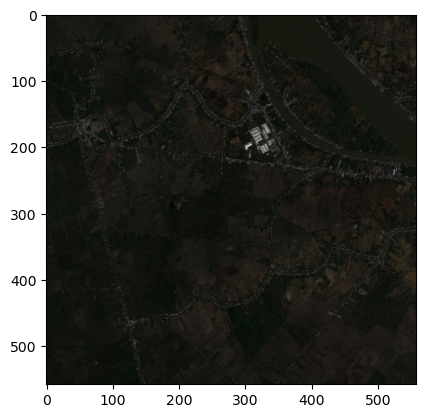

In [10]:
plt.imshow(img_array/10000)

In [11]:
img_data = (img_array * (255 / img_array.max())).astype(np.uint8)

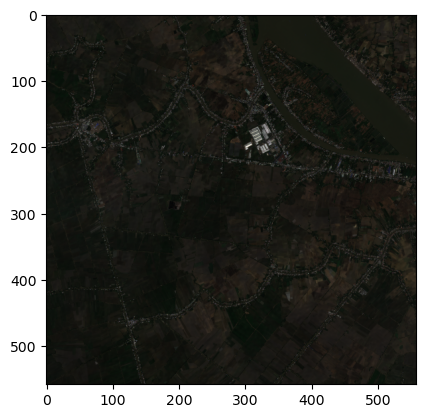

In [12]:
plt.imshow(img_data)

Thats why we usually clip data between 0-0.3 or 0-0.4, of course this cut off some values since all the values greater than this maximum limit wil be set up to this limit value(0.3 or 0.4). Then we will stretch  those values to 0-1 scale,so we will obtain the same proportion distribution but with higher values generating brighter images

In [13]:
img_array_cutoff = np.clip(img_array/10000, 0, 0.3)  # divide with 10000 and cut of to range [0.0, 0.3]
img_array_bright = img_array_cutoff/0.3  # stretch to [0.0, 1.0]

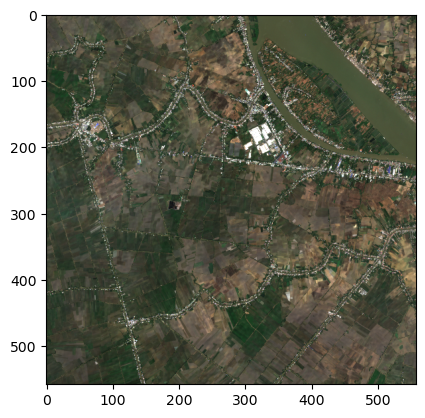

In [14]:
plt.imshow(img_array_bright)

Of course we can scale up this float 0-1 range into typical colormap range 0-255

In [15]:
img_array_bright_255 = (img_array_bright*255).astype(np.uint8) 

Instead of this process we can directly multiply 0-1 initial reflentance values by a factor to increase low values, trying to mantain most of the values between 0-1. Values greater than 1 after multiplication will be clipped automatically by matplotlib to 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


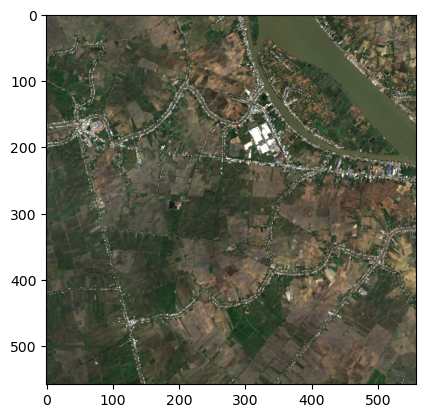

In [16]:
plt.imshow(img_array/10000 * 3.5)

We can plot using xarray plot function that already perform all those transformations to visualize sentinel data images properly:

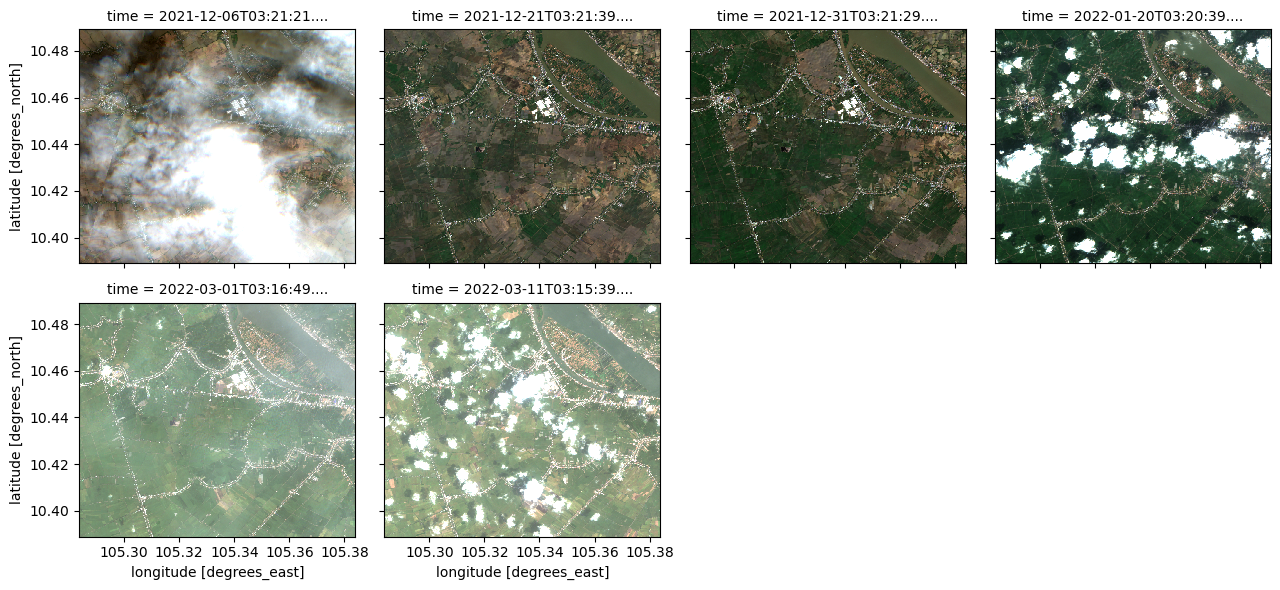

In [17]:
plot_xx = xx[["B04","B03","B02"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=3000)
plt.show()

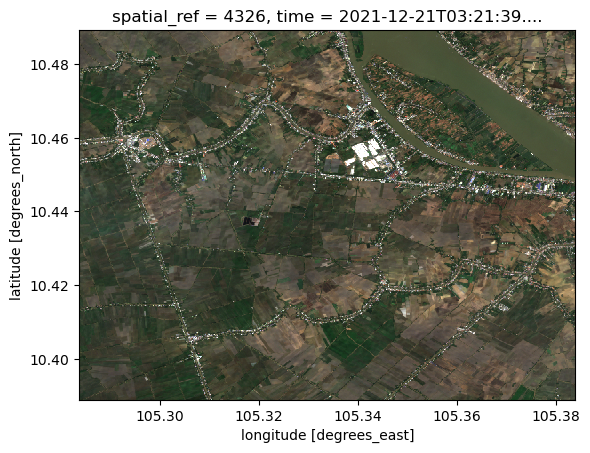

In [18]:
xx.isel(time=1)[["B04","B03","B02"]].to_array().plot.imshow(robust=True, vmin=0, vmax=3000)
plt.show()

## Cloud filtering

In [19]:
# Filter data using the Sentinel-2 SCL band classification

# SCL band mask classes:
# 0  - NODATA - MAGENTA
# 1  - Saturated or Defective - RED
# 2  - Dark Areas - BLACK
# 3  - Cloud Shadow - DARK GREY
# 4  - Vegetation - GREEN
# 5  - Bare Ground - BROWN
# 6  - Water - BLUE
# 7  - Unclassified - MAROON
# 8  - Cloud - LIGHT GREY
# 9  - Definitely Cloud - WHITE
 # 10 - Thin Cloud - LIGHT BLUE
# 11 - Snow or Ice - PINK

#We have to filter the followign classes
# scl=0 > No Data
# scl=1 > Saturated
# scl=3 > Cloud Shadows
# scl=6 > Water 
# scl=8 > Cloud Medium Probability 
# scl=9 > Cloud High Probability
# scl=10 > Thin Cirrus Cloud


# Create a mask for no data, saturated data, clouds, cloud shadows, and water

cloud_mask = \
    (xx.SCL != 0) & \
    (xx.SCL != 1) & \
    (xx.SCL != 3) & \
    (xx.SCL != 6) & \
    (xx.SCL != 8) & \
    (xx.SCL != 9) & \
    (xx.SCL != 10) 

In [20]:
# Apply cloud mask ... NO Clouds, NO Cloud Shadows and NO Water pixels
# All masked pixels are converted to "No Data" and stored as 16-bit integers
cleaned_data = xx.where(cloud_mask).astype("uint16")

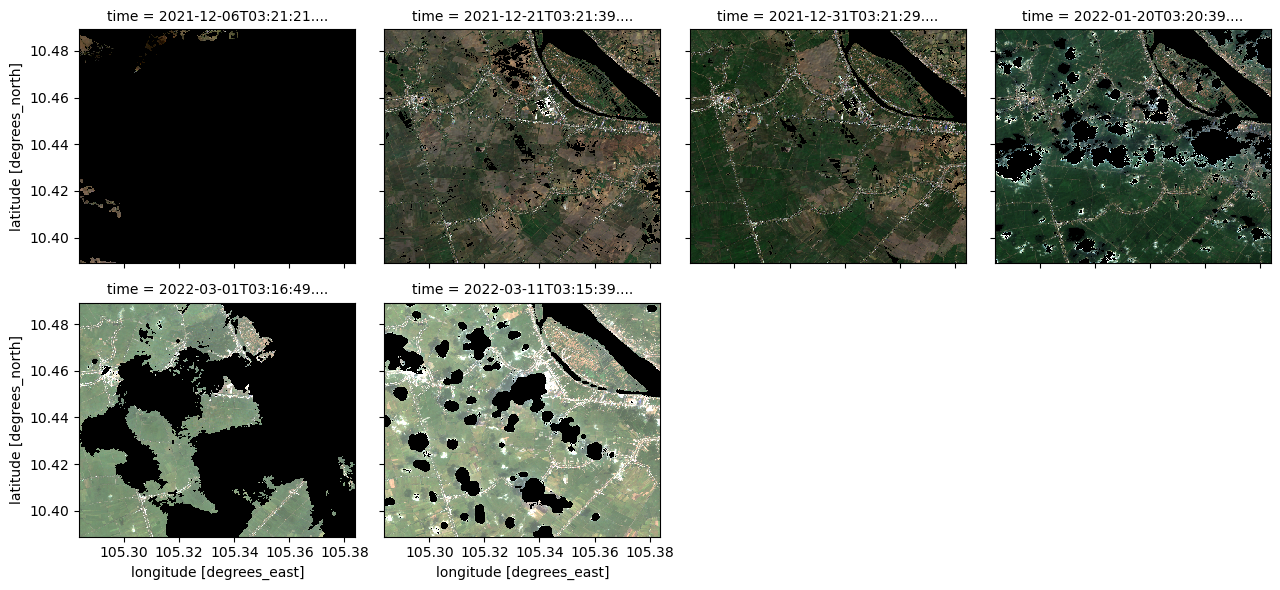

In [21]:
plot_cleaned = cleaned_data[["B04","B03","B02"]].to_array()
plot_cleaned.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=3000)
plt.show()

As we can see in top left corner, even filtering the images at the beggining with a low probability of clouds query, those clouds that are diffused are entirely set to 0. Since we don't want to train our model with very sparsed data we will filter those images.

In [22]:
def sparsity_ratio(img_xarray):
    img_array_np = img_xarray.values  # Convert xarray to NumPy array
    img_flat = img_array_np.reshape((-1,))
    num_zeros = np.count_nonzero(img_flat == 0)
    
    return num_zeros / img_flat.size

# Preparing training/validation dataset

In [8]:
crop_location_df = pd.read_csv("Crop_Location_Data_clean.csv")

In [9]:
crop_location_df

Latitude and Longitude Class of Land
0     (10.323727047081501, 105.2516346045924)          Rice
1    (10.322364360592521, 105.27843410554115)          Rice
2    (10.321455902933202, 105.25254306225168)          Rice
3    (10.324181275911162, 105.25118037576274)          Rice
4    (10.324635504740822, 105.27389181724476)          Rice
..                                        ...           ...
595  (10.013942985253381, 105.67361318732796)      Non Rice
596   (10.01348875642372, 105.67361318732796)      Non Rice
597  (10.013034527594062, 105.67361318732796)      Non Rice
598  (10.012580298764401, 105.67361318732796)      Non Rice
599  (10.012126069934741, 105.67361318732796)      Non Rice

[600 rows x 2 columns]

In [23]:
def sparsity_ratio(img_xarray):
    img_array_np = img_xarray.values  # Convert xarray to NumPy array
    img_flat = img_array_np.reshape((-1,))
    num_zeros = np.count_nonzero(img_flat == 0)
    
    return num_zeros / img_flat.size

def process_lat_long(lat_long, time_window="2021-12-01/2022-04-30", cloud_cover_threshold=100, box_size_deg = 0.10, sparsity_threshold=0):
    # Same code as before to calculate the bounding box, open the STAC catalog, get items, and load the xarray

    # Calculate the Lat-Lon bounding box region
    min_lon = lat_long[1]-box_size_deg/2
    min_lat = lat_long[0]-box_size_deg/2
    max_lon = lat_long[1]+box_size_deg/2
    max_lat = lat_long[0]+box_size_deg/2
    bounds = (min_lon, min_lat, max_lon, max_lat)

    #Opening stat catalog
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    #Getting items from stac catalog using a given bounding box
    search = stac.search(collections=["sentinel-2-l2a"], bbox=bounds, datetime=time_window, query={"eo:cloud_cover": {"lt": 40}})
    items = list(search.get_all_items())

    # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees
    resolution = 20  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for CRS:4326 


    xx = stac_load(
        items,
        crs="EPSG:4326", # Latitude-Longitude
        resolution=scale, # Degrees
        chunks={"x": 2048, "y": 2048},
        dtype="uint16",
        patch_url=pc.sign,
        bbox=bounds
    )
    
    # Create a mask for no data, saturated data, clouds, cloud shadows, and water
    cloud_mask = \
        (xx.SCL != 0) & \
        (xx.SCL != 1) & \
        (xx.SCL != 3) & \
        (xx.SCL != 6) & \
        (xx.SCL != 8) & \
        (xx.SCL != 9) & \
        (xx.SCL != 10)

    # Apply the cloud mask
    cleaned_data = xx.where(cloud_mask).astype("uint16")

    # Calculate sparsity ratio for each image in the dataset
    sparsity_ratios = []
    for i in range(len(cleaned_data.time)):
        img_array = cleaned_data.isel(time=i)[["B04", "B03", "B02"]].to_array()
        sparsity_ratios.append(sparsity_ratio(img_array))

    # Filter the images with a sparsity ratio less than or equal to the threshold
    filtered_indices = [i for i, ratio in enumerate(sparsity_ratios) if ratio <= sparsity_threshold]

    # If all images have a sparsity ratio greater than the threshold, select the least sparse image, to prevent the lack of images for any location
    if not filtered_indices:
        least_sparse_index = np.argmin(sparsity_ratios)
        filtered_indices = [least_sparse_index]

    filtered_data = cleaned_data.isel(time=filtered_indices)

    # Get sparsity_ratios for the filtered images only
    filtered_sparsity_ratios = [sparsity_ratios[i] for i in filtered_indices]

    return filtered_data, filtered_sparsity_ratios

In [86]:
test, sparsity_ratios = process_lat_long((10.4391, 105.3338), time_window="2021-12-01/2022-04-30", cloud_cover_threshold=40, box_size_deg = 0.10, sparsity_threshold=0.5)

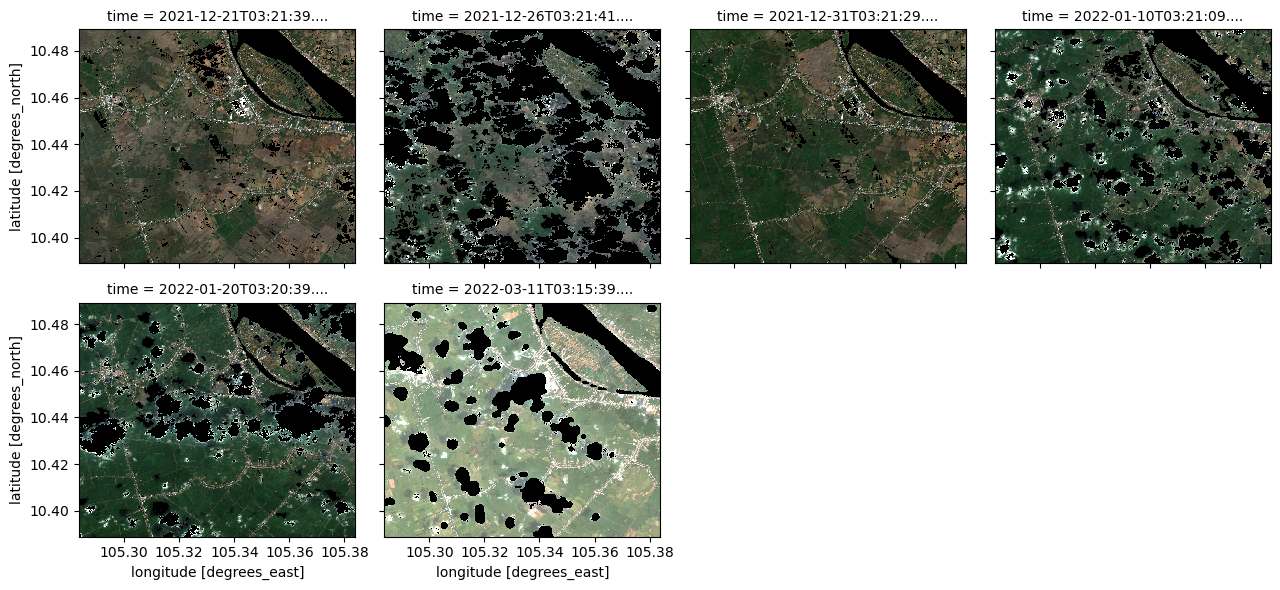

In [87]:
plot_test = test[["B04","B03","B02"]].to_array()
plot_test.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=3000)
plt.show()

In [88]:
sparsity_ratios

[0.10719286751197955,
 0.4969906604488637,
 0.08105946737580452,
 0.21691332331290708,
 0.21851916085353476,
 0.17592271425084466]

In [65]:
import os
import xarray as xr
import h5py
from tqdm import tqdm

def save_imgs_from_locations(df, label_available, folder_path):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    # Iterate over the df dataframe
    for index, row in tqdm(df.iterrows(), desc="Processing lat/long pairs"):
        lat_long = row["Latitude and Longitude"]
        if label_available:
            label = row["Class of Land"]
        else:
            label = None
        lat_long = tuple(map(float, lat_long.strip("()").split(",")))
        
        # Call the process_lat_long function for each lat/long pair and get both filtered_data and sparsity_ratios
        filtered_data, sparsity_ratios = process_lat_long(lat_long, sparsity_threshold=0)
        
        # Print the number of images collected for the current location
        print(f"Number of images collected for lat/long {lat_long}: {len(filtered_data.time)}")
        
        # Check if there are no images for that position
        if len(filtered_data.time) == 0:
            print(f"No images collected for lat/long {lat_long}")
            continue
        
        # Iterate over the filtered_data and calculate NDVI and NDMI for each time step
        for i in range(len(filtered_data.time)):
            red_band = filtered_data["B04"].isel(time=i)
            nir_band = filtered_data["B08"].isel(time=i)
            swir_band = filtered_data["B11"].isel(time=i)

            ndvi = (nir_band - red_band) / (nir_band + red_band)
            ndmi = (nir_band - swir_band) / (nir_band + swir_band)
            
            # Create a HDF5 file for each image
            filename = os.path.join(folder_path, f"{lat_long[0]}_{lat_long[1]}_{i}.h5")
            if os.path.exists(filename):
                print(f"File {filename} already exists. Skipping...")
                continue
            with h5py.File(filename, "w") as f:
                f.create_dataset("latitude_longitude", data=lat_long)
                if label_available:
                    f.create_dataset("label", data=label)
                f.create_dataset("time_index", data=i)
                f.create_dataset("AOT", data=filtered_data["AOT"].isel(time=i).values)
                f.create_dataset("B01", data=filtered_data["B01"].isel(time=i).values)
                f.create_dataset("B02", data=filtered_data["B02"].isel(time=i).values)
                f.create_dataset("B03", data=filtered_data["B03"].isel(time=i).values)
                f.create_dataset("B04", data=filtered_data["B04"].isel(time=i).values)
                f.create_dataset("B05", data=filtered_data["B05"].isel(time=i).values)
                f.create_dataset("B06", data=filtered_data["B06"].isel(time=i).values)
                f.create_dataset("B07", data=filtered_data["B07"].isel(time=i).values)
                f.create_dataset("B08", data=filtered_data["B08"].isel(time=i).values)
                f.create_dataset("B09", data=filtered_data["B09"].isel(time=i).values)
                f.create_dataset("B11", data=filtered_data["B11"].isel(time=i).values)
                f.create_dataset("B12", data=filtered_data["B12"].isel(time=i).values)
                f.create_dataset("B8A", data=filtered_data["B8A"].isel(time=i).values)
                f.create_dataset("NDMI", data=ndmi.values)
                f.create_dataset("NDVI", data=ndvi.values)
                f.create_dataset("SCL", data=filtered_data["SCL"].isel(time=i).values)
                f.create_dataset("WVP", data=filtered_data["WVP"].isel(time=i).values)
                f.create_dataset("sparsity", data=sparsity_ratios[i])
                f.create_dataset("visual", data=filtered_data["visual"].isel(time=i).values)

In [ ]:
save_imgs_from_locations(crop_location_df, label_available=True, folder_path="sentinel_2_least_sparsed")

## Checking integrity of the datasets and ploting images

In [24]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
def check_img_dataset(folder_path):
    hdf_files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

    # Print the total number of images
    print(f"Total number of images: {len(hdf_files)}")

    # Define the bands you want to check
    bands = ["B02", "B03", "B04"]

    error_log = []

    for hdf_file in hdf_files:
        with h5py.File(os.path.join(folder_path, hdf_file), "r") as f:
            print(f"Checking file: {hdf_file}")

            # Check if all required keys are present
            keys = f.keys()
            for band in bands:
                if band not in keys:
                    error_message = f"Error: {band} not found in {hdf_file}"
                    print(error_message)
                    error_log.append(error_message)

            # Print the shape of each band
            for band in bands:
                shape = f[band].shape
                print(f"{band} in {hdf_file} has a shape of {shape}")

            # Display the processed image
            img_array = np.stack([np.array(f[band]) for band in bands], axis=-1)
            img_array_cutoff = np.clip(img_array / 10000, 0, 0.3)
            img_array_bright = img_array_cutoff / 0.3
            plt.imshow(img_array_bright)
            plt.show()


In [ ]:
check_img_dataset(folder_path="sentinel_2_least_sparsed")

# Training models

## Training using resnet50, one image per location(least sparsed image), sentinel 2 data - NDVI,NDVI and NIR band as input channels

In [25]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, folder_path, bands=None, transform=None, label_provided=True):
        self.folder_path = folder_path
        self.transform = transform
        
        # Get the list of all HDF5 files in the folder
        self.hdf_files = [f for f in os.listdir(self.folder_path) if f.endswith('.h5')]
        
        # Check if bands are provided, otherwise use default bands
        self.bands = bands
        
        self.label_provided = label_provided
    
    def __len__(self):
        return len(self.hdf_files)
    
    def __getitem__(self, idx):
        with h5py.File(os.path.join(self.folder_path, self.hdf_files[idx]), "r") as f:
            # Read the dataset from the HDF5 file
            dataset = {}
            for k in f.keys():
                dataset[k] = np.array(f[k])

            # Apply the desired band combination
            bands = self.bands
            img = np.stack([dataset[b] for b in bands], axis=-1)

            # Apply the new transformation
            img = np.clip(img / 10000.0, 0, 0.3)  # divide with 10000 and cut of to range [0.0, 0.3]
            img = img / 0.3  # stretch to [0.0, 1.0]

            # Transforms
            img = img * 255
            img = img.astype(np.uint8)  # Convert the data type to uint8
        
            if self.transform:
                img = self.transform(img)
            
            if self.label_provided:
                # Get the label
                label = dataset["label"]
                label = 1 if label == b'Rice' else 0  # Convert string labels to numbers (1 for 'Rice', 0 for 'Non Rice')
                label = torch.tensor(label, dtype=torch.long)  # Convert the label to a PyTorch tensor
                return img, label
            
            else:
                return img

# Define the transforms
train_transform = transforms.Compose([
                    transforms.ToPILImage(), 
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(45),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])


val_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])



### Simple Training

In [28]:
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split


# Define the folder path and bands to use
folder_path = "sentinel_2_least_sparsed"
bands = ["NDVI", "NDMI", "B08"]
batch_size = 8

# Create the dataset and split the indices
dataset = CustomDataset(folder_path, bands, transform=train_transform)
train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

# Create the train and validation datasets
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

# Apply the transforms to the datasets
val_dataset.transform = val_transform

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size, shuffle=False)

In [29]:
from torch import nn
from torchvision.models import resnet50


# Load the pre-trained ResNet50 model
model = resnet50(pretrained=True)

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False
model.fc.requires_grad = True

# Change the output layer to a binary classifier
model.fc = nn.Linear(2048, 2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)  


# Move the model to the GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Train the model
num_epochs = 4
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    # Training
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_acc = (outputs.argmax(1) == labels).sum().item() / labels.size(0)

        train_loss += batch_loss
        train_acc += batch_acc * labels.size(0)

        print(f"Train Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {batch_loss:.4f}, Acc: {batch_acc:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_loss = loss.item()
            batch_acc = (outputs.argmax(1) == labels).sum().item() / labels.size(0)

            val_loss += batch_loss
            val_acc += batch_acc * labels.size(0)

            print(f"Val Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {batch_loss:.4f}, Acc: {batch_acc:.4f}")

    # Calculate average metrics for the epoch
    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)
    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Train Epoch [1/4], Batch [1/60], Loss: 0.6802, Acc: 0.5000
Train Epoch [1/4], Batch [2/60], Loss: 1.0253, Acc: 0.3750
Train Epoch [1/4], Batch [3/60], Loss: 0.6986, Acc: 0.3750
Train Epoch [1/4], Batch [4/60], Loss: 0.7060, Acc: 0.3750
Train Epoch [1/4], Batch [5/60], Loss: 0.6584, Acc: 0.5000
Train Epoch [1/4], Batch [6/60], Loss: 0.5102, Acc: 0.6250
Train Epoch [1/4], Batch [7/60], Loss: 0.3946, Acc: 0.8750
Train Epoch [1/4], Batch [8/60], Loss: 0.3244, Acc: 1.0000
Train Epoch [1/4], Batch [9/60], Loss: 0.3936, Acc: 0.8750
Train Epoch [1/4], Batch [10/60], Loss: 0.4590, Acc: 1.0000
Train Epoch [1/4], Batch [11/60], Loss: 0.5066, Acc: 0.8750
Train Epoch [1/4], Batch [12/60], Loss: 0.4431, Acc: 0.8750
Train Epoch [1/4], Batch [13/60], Loss: 0.4086, Acc: 0.8750
Train Epoch [1/4], Batch [14/60], Loss: 0.4910, Acc: 0.8750
Train Epoch [1/4], Batch [15/60], Loss: 0.4706, Acc: 0.8750
Train Epoch [1/4], Batch [16/60], Loss: 0.4292, Acc: 0.7500
Train Epoch [1/4], Batch [17/60], Loss: 0.2683, A

### Training with K-fold cross validation

In [30]:
del model

In [31]:
### import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch import nn
from torchvision.models import resnet50
from torch.optim import Adam
from sklearn.model_selection import KFold
from copy import deepcopy


folder_path = "sentinel_2_least_sparsed"
bands = ["NDVI", "NDMI", "B08"]
batch_size = 8

# Create the dataset
dataset = CustomDataset(folder_path, bands, transform=train_transform)

# K-fold cross-validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize lists to store the fold-wise results
val_losses = []
val_accuracies = []

# Run the k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Create the train and validation datasets
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    # Apply the transforms to the datasets
    val_dataset.transform = val_transform

    # Create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Load the pre-trained ResNet50 model
    model = resnet50(pretrained=True)

    # Freeze all layers except the last one
    for param in model.parameters():
        param.requires_grad = False
    model.fc.requires_grad = True

    # Change the output layer to a binary classifier
    model.fc = nn.Linear(2048, 2)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters())

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Train the model with early stopping
    num_epochs = 4
    patience = 5
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # Training
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            batch_acc = (outputs.argmax(1) == labels).sum().item() / labels.size(0)
            train_loss += batch_loss
            train_acc += batch_acc * labels.size(0)

            print(f"Train Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {batch_loss:.4f}, Acc: {batch_acc:.4f}")

        # Validation
        model.eval()
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)


                batch_loss = loss.item()
                batch_acc = (outputs.argmax(1) == labels).sum().item() / labels.size(0)

                val_loss += batch_loss
                val_acc += batch_acc * labels.size(0)

        # Calculate average metrics for the epoch
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        val_loss /= len(val_dataset)
        val_acc /= len(val_dataset)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping.")
            break

# Use the best model for evaluation on the validation set for this fold
model = best_model
model.eval()
fold_val_loss = 0
fold_val_acc = 0
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        batch_loss = loss.item()
        batch_acc = (outputs.argmax(1) == labels).sum().item() / labels.size(0)

        fold_val_loss += batch_loss
        fold_val_acc += batch_acc * labels.size(0)

# Calculate average metrics for the fold
fold_val_loss /= len(val_dataset)
fold_val_acc /= len(val_dataset)

print(f"Fold {fold + 1}/{k_folds}, Val Loss: {fold_val_loss:.4f}, Val Acc: {fold_val_acc:.4f}")

# Append fold-wise results
val_losses.append(fold_val_loss)
val_accuracies.append(fold_val_acc)



Fold 1/5
Train Epoch [1/4], Batch [1/60], Loss: 0.6461, Acc: 0.7500
Train Epoch [1/4], Batch [2/60], Loss: 0.5205, Acc: 0.7500
Train Epoch [1/4], Batch [3/60], Loss: 0.8677, Acc: 0.5000
Train Epoch [1/4], Batch [4/60], Loss: 0.4677, Acc: 0.7500
Train Epoch [1/4], Batch [5/60], Loss: 0.4973, Acc: 0.8750
Train Epoch [1/4], Batch [6/60], Loss: 0.5895, Acc: 0.7500
Train Epoch [1/4], Batch [7/60], Loss: 0.8503, Acc: 0.3750
Train Epoch [1/4], Batch [8/60], Loss: 0.3848, Acc: 0.7500
Train Epoch [1/4], Batch [9/60], Loss: 0.7579, Acc: 0.3750
Train Epoch [1/4], Batch [10/60], Loss: 0.5836, Acc: 0.7500
Train Epoch [1/4], Batch [11/60], Loss: 0.4973, Acc: 0.7500
Train Epoch [1/4], Batch [12/60], Loss: 0.6877, Acc: 0.5000
Train Epoch [1/4], Batch [13/60], Loss: 0.4158, Acc: 0.7500
Train Epoch [1/4], Batch [14/60], Loss: 0.3810, Acc: 0.8750
Train Epoch [1/4], Batch [15/60], Loss: 0.6256, Acc: 0.6250
Train Epoch [1/4], Batch [16/60], Loss: 0.6088, Acc: 0.6250
Train Epoch [1/4], Batch [17/60], Loss: 